This is a presentation and explanation of the code.

The first part of the code is the definition of some functions, used to solve the problems of three groups, namely

Group A: Methods for ODE initial-value problems, that is, using Euler method or Runge-Kutta method to solve ivp;

Group B: Methods for numerical continuation, specifically Natural parameter continuation;

Group C: Methods for ODE boundary-value problems, that is, Finite-difference methods implemented with SciPy’s root-finding functions or using NumPy with dense matrices. Here, just SciPy's functions.

Because it is different in this compiler and in vscode, there are some changes in the code, but the changes are very small.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.signal import find_peaks
import time
from scipy.optimize import root


'''
solve_to
'''
# Perform a single Euler step
def euler_step(f, x0, t0, dt):
    return x0 + dt * f(x0, t0)

# Perform a single RK4 step
def rk4_step(f, x0, t0, dt):
    k1 = dt * f(x0, t0)
    k2 = dt * f(x0 + 0.5 * k1, t0 + 0.5 * dt)
    k3 = dt * f(x0 + 0.5 * k2, t0 + 0.5 * dt)
    k4 = dt * f(x0 + k3, t0 + dt)
    return x0 + (k1 + 2*k2 + 2*k3 + k4) / 6

# Solve the ODE x' = f from t0 to t1 using the Euler method or RK4
def solve_to(f, x0, t0, t1, dt_max, method):

    t_values = [t0]
    x_values = [x0]
    t = t0
    x = x0

    while t < t1:
        dt = min(dt_max, t1 - t)   # Prevent t from exceeding t1
        if method == 'euler':   # Choose method
            x = euler_step(f, x, t, dt)
        elif method == 'rk4':
            x = rk4_step(f, x, t, dt)
        t += dt
        t_values.append(t)
        x_values.append(x)

    return np.array(t_values), np.array(x_values)

'''
calculate_error
'''
# Analytical solution of the ODE
def analytical_solution(t):
    return np.exp(t)

# Calculate error based on method parameter
def calculate_error(f, x0, t0, t1, dt_values, method):
    errors = []

    for dt in dt_values:
        t_numerical, x_numerical = solve_to(f, x0, t0, t1, dt, method)
        x_analytical = analytical_solution(t_numerical)
        error = np.abs(x_numerical[-1] - x_analytical[-1])
        errors.append(error)

    return errors

'''
scipy.odeint
ode_solver
'''
# Directly use the odeint function to solve ode
def ode_solver(ode_func, initial_conditions, t_span, *args, **kwargs):
    solution = odeint(ode_func, initial_conditions, t_span, args, **kwargs)
    t = t_span if hasattr(t_span, '__len__') else [t_span[0], t_span[-1]]
    return t, solution

'''
numerical_shooting
'''
# Try to achieve numerical shooting
def numerical_shooting(ode_func, t_span, initial_conditions, initial_guess, *args, tol=0.1, max_iter=1000, **kwargs):
    
    def objective_function(y, t_span):
        _, y_solution = ode_solver(ode_func, y, t_span, *args)
        return initial_guess - y_solution[-1]   
    
    
    # Perform shooting method
    for _ in range(max_iter):
        # Solve the ODE system with the current initial conditions
        solution = odeint(ode_func, initial_conditions, t_span, args, **kwargs)
        
        # Check the phase condition
        if np.allclose(solution[-1], initial_guess, atol=tol):
            # If phase condition is met, compute period and return
            period = compute_period(solution[:, 0], t_span)
            return initial_conditions, period
        
        # Use Newton's method to update the initial conditions
        initial_conditions -= (objective_function(initial_conditions, t_span) / np.gradient(ode_func(initial_conditions, t_span, *args)))
    
    raise ValueError("Numerical shooting did not converge within the maximum number of iterations.")
    
'''
has_periodicity
'''
# Used to determine whether the solution is periodic
def has_periodicity(sequence):
    highpeaks, _  = find_peaks(sequence)
    lowpeaks, _ = find_peaks(-sequence)
    high = np.diff(highpeaks)
    low = np.diff(lowpeaks)
    print(high)
    print(low)
    print(np.std(high[5:-1]))
    print(np.std(low[5:-1]))
    if np.std(high[5:-1]) < 1 and np.std(low[5:-1]) < 1:
        return True
    else:
        return False

'''
compute the period
'''
# used to calculate period of the solution
def compute_period(solution, t_span):
    peaks, _ = find_peaks(solution)
    print(peaks)
    if len(peaks) < 2:
        # If not enough peaks are found, return a default value or throw an exception
        return np.nan  
    period = (t_span[1]-t_span[0])*(peaks[1]-peaks[0])
    return period

'''
use scipy.solve_bvp
solve_bvp
'''
def bvp_residuals(ode_func, guess, t_span, x_end):
    sol = solve_ivp(lambda t, xy: ode_func(t, xy), t_span, [guess[0], guess[1]], t_eval=[t_span[1]])
    return sol.y[0][-1] - x_end

def solve_bvp(ode_func, t_span, x_end, guess):
    solution = minimize(bvp_residuals, guess, args=(ode_func, t_span, x_end), method='BFGS')
    return solution.x

'''
numerical continuation
'''
# Step 1: Find the equilibrium points
def equilibrium_points(ode_sys, *args):
    # Define the equations for root finding
    equilibria = []
    sol = root(ode_sys, [0,0], args)
    if sol.success:
        equilibria.append(sol.x)
    return equilibria

# Step 2: Linear stability analysis
def stability_analysis(A, B, equilibria):
    for equilibrium in equilibria:
        x, y = equilibrium
        # Jacobian matrix
        J = [[2 * x * y - (B + 1), x**2], [B - 2 * x * y, -x**2]]
        # Eigenvalues
        eigenvalues = np.linalg.eigvals(J)
        # Check stability
        if all(np.real(eig) < 0 for eig in eigenvalues):
            print(f"Equilibrium point {equilibrium} is stable.")
        else:
            print(f"Equilibrium point {equilibrium} is unstable.")

def has_periodicity(sequence):
    highpeaks, _  = find_peaks(sequence)
    lowpeaks, _ = find_peaks(-sequence)
    high = np.diff(highpeaks)
    low = np.diff(lowpeaks)
    if np.std(high[5:-1]) < 1 and np.std(low[5:-1]) < 1:
        return True
    else:
        return False
    



# Step 4: Plot the limit cycles
def plot_limit_cycles(dydt, A, B):
    # Define the function to solve ODE for a given B
    def solve_ode(B):
        equilibria = equilibrium_points(dydt, A, B)
        x0, y0 = equilibria[0]
        sol = solve_ivp(lambda t, y: dydt(t, y, A, B), [0, 10], [x0, y0], t_eval=np.linspace(0, 10, 100))
        return sol.y

    # Plot the limit cycles for B in range [2, 3]
    B_values = np.linspace(2, 3, 51)
    for B in B_values:
        xy = solve_ode(B)
    plt.plot(xy[0], xy[1], color='b', alpha=0.3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Limit Cycles for B in [2, 3]')
    plt.grid(True)
    plt.show()

'''
finite_difference
'''
def finite_difference(ode_fun, grid_num, interval,  *args):
    #Step1 get the grid
    a, b = interval
    grid = np.linspace(a, b, grid_num+1)
    #Step2 Construct equations
    q = [] #-q is the right hand side of the equation
    
    for xi in grid:
        q.append(ode_fun(xi, [0,0], *args)) #the value of u and v is not important here
    
    h = grid[1] - grid[0] #step size
    
    # Define the system of equations to be solved to solve u
    def F(u):
        eq = np.zeros(grid_num-1)
        eq[0] = (u[1] - 2*u[0] + 1) / h**2 - ode_fun(grid[1], [0,0], *args)[1]
        for i in range(1, grid_num-3):
            eq[i] = (u[i+1] - 2*u[i] + u[i-1]) / h**2 - ode_fun(grid[i+1], [0,0], *args)[1]
        eq[grid_num-2] = (-1 - 2*u[grid_num-2] + u[grid_num-3]) / h**2 - ode_fun(grid[grid_num-1], [0,0], *args)[1]
        return eq
    
    #Step3 solve the equation
    u = root(F, np.zeros(grid_num-1)).x
    
    return u




Import the packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
# Import the module that solves the initial value problem

1-a 

Just initialize the required AB and initial value to solve it with the ode_solver function, then find the solution of x, y and draw the graph. 

The first step is to define the ode system, then initialize it, and then use functions to solve it. The obtained results include x and y, so they need to be taken out separately. The t used is the time point corresponding to each x and y. That is, the image of y-x, the image of xy-t can be drawn separately, and even an image of the entire system regarding time.

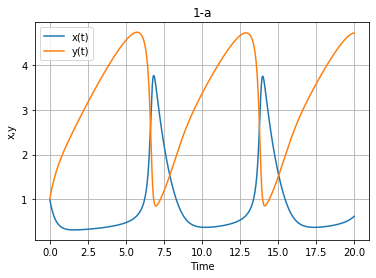

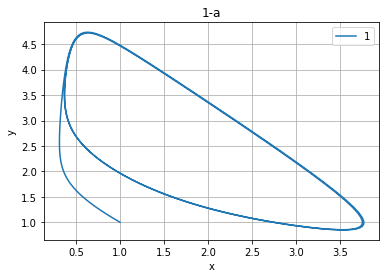

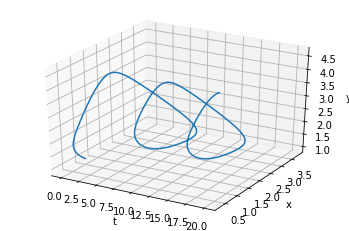

In [3]:
'''
1_a
'''
# Define the ode system for Q1a
def a1_ode_system(xy, t, A, B):
    x, y = xy
    dxdt = A + x**2 * y - (B + 1) * x
    dydt = B * x - x**2 * y
    return [dxdt, dydt]

# Set initial values
A = 1
B = 3
xy0 = [1, 1]  # Initial conditions
t_span = np.linspace(0, 20, 1001)  # time limit

# Solve the ode
t, solution = ode_solver(a1_ode_system, xy0, t_span, A, B)

# Get the solution
x_solution_a = solution[:, 0]
y_solution_a = solution[:, 1]

# Plot the solution as x-t and y-t graphs
plt.plot(t, x_solution_a, label='x(t)')
plt.plot(t, y_solution_a, label='y(t)')
plt.xlabel('Time')
plt.ylabel('x,y')
plt.title('1-a')
plt.legend()
plt.grid(True)
plt.show()

# Plot the limit cycle
plt.plot(x_solution_a,y_solution_a,label='1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('1-a')
plt.legend()
plt.grid(True)
plt.show()

# Plot phase diagram
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(t, x_solution_a, y_solution_a)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('y')
plt.show()

1-c

For numerical continuation, in this part I just found the corresponding equilibrium solution during the change of B, and then plotted it

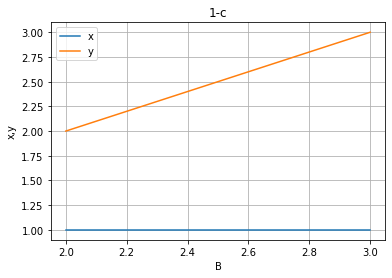

In [4]:
'''
1-c
'''
def equations(xy, A, B):
    x, y = xy
    return [A + x**2 * y - (B + 1) * x, B * x - x**2 * y]
A = 1
B = 2
B_values = np.linspace(2, 3, 101)
t_span = np.linspace(0, 100, 1001)
initial_condition = equilibrium_points(equations, A, B)[0]

x = []
y = []
for B in B_values:
    xy = root(partial(equations, A=A, B=B), initial_condition).x
    x.append(xy[0])
    y.append(xy[1])

plt.plot(B_values, x, label='x')
plt.plot(B_values, y, label='y')
plt.xlabel('B')
plt.ylabel('x,y')
plt.title('1-c')
plt.legend()
plt.grid(True)
plt.show()

2-a

2-a is very similar to 1-a, except that the dimensions have changed. It can be solved using the same steps.

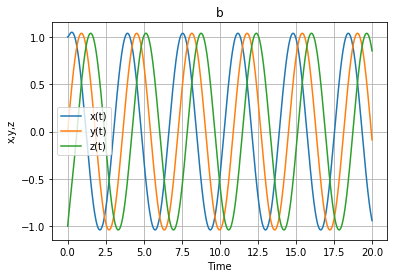

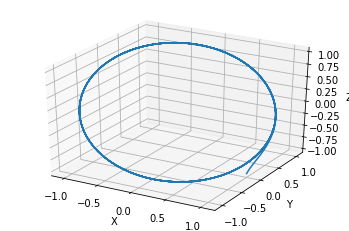

In [5]:
'''
2_a
'''
#Define the ode system for Q2a
def a2_ode_system(xyz, t, beta):
    x, y, z = xyz
    dxdt = beta * x - y - z + x * (x**2 + y**2 + z**2) - x * (x**2 + y**2 + z**2)**2
    dydt = x + beta * y - z + y * (x**2 + y**2 + z**2) - y * (x**2 + y**2 + z**2)**2
    dzdt = x + y + beta * z + z * (x**2 + y**2 + z**2) - z * (x**2 + y**2 + z**2)**2
    return [dxdt, dydt, dzdt]

#Set initial values
beta = 1
xyz0 = [1, 0, -1]
t_span = np.linspace(0, 20, 1001)

#Solve the ode
t, solution = ode_solver(a2_ode_system, xyz0, t_span, beta)

#Get the solution
x_solution_b = solution[:, 0]
y_solution_b = solution[:, 1]
z_solution_b = solution[:, 2]

#Plot the solution
plt.plot(t, x_solution_b, label='x(t)')
plt.plot(t, y_solution_b, label='y(t)')
plt.plot(t, z_solution_b, label='z(t)')
plt.xlabel('Time')
plt.ylabel('x,y,z')
plt.title('b')
plt.legend()
plt.grid(True)
plt.show()

# Plot the limit cycle
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_solution_b, y_solution_b, z_solution_b)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

3-a

In this part, I first define ode and then initialize the values that need to be used. Then we used the finite_difference function to find ui, and added the first and last ui. Because we brought the values of u0 and uN directly into the equation, these two values ​​are missing and need to be added, and finally the image is drawn.

The value of u(0) is approximately: 0.8795


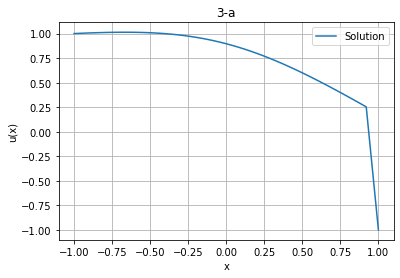

In [6]:
'''
3_a
'''
def poisson_eq(x, state, sigma):
    u, v = state
    # Compute the derivative of u with respect to x
    du_dx = v
    # Compute the second derivative of u with respect to x
    dv_dx = - (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-x**2 / (2 * sigma**2))
    # Return the system of ODEs
    return np.array([du_dx, dv_dx])

grid_num = 50
interval = (-1, 1)
sigma = 0.5

result = finite_difference(partial(poisson_eq, sigma=sigma), grid_num, interval)
print(f"The value of u(0) is approximately: {result[grid_num//2]:.4f}")

new_result = np.zeros(len(result) + 2)
new_result[1:-1] = result
new_result[0] = 1  # Fill in the first and last values
new_result[-1] = -1  
result = new_result

# Plot the solution
plt.plot(np.linspace(-1, 1, grid_num + 1), result, label='Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('3-a')
plt.grid(True)
plt.legend()
plt.show()

6-a

This part is the same as 3-a, but I implemented it directly here without writing it into a module. This is an existing problem. But the implementation logic is the same.

when P = 1, max: 0.5000
when P = 10, max: 0.6206
when P = 50, max: 0.8526


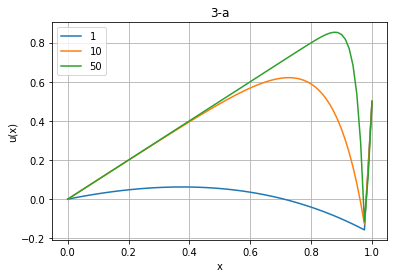

In [7]:
'''
6_a
'''
def ode_fun(x, state, P):
    u, v = state
    du_dx = v
    dv_dx = P * v - P
    return np.array([du_dx, dv_dx])

#Step1 get the grid
a = 0
b = 1
grid_num = 80
grid = np.linspace(a, b, grid_num+1)

#Step2 Construct equations and solve    
h = grid[1] - grid[0] #step size
for P in [1, 10, 50]:
    def F(u):
        eq = np.zeros(grid_num-1)
        eq[0] = (u[1] - 2*u[0] + 0) / h**2 - P * ((u[0] - 0) / h) + P
        for i in range(1, grid_num-3):
            eq[i] = (u[i+1] - 2*u[i] + u[i-1]) / h**2 - P * ((u[i] - u[i-1]) / h) + P
        eq[grid_num-2] = (0.5 - 2*u[grid_num-2] + u[grid_num-3]) / h**2 - P * ((u[grid_num-2] - u[grid_num-3]) / h) + P
        return eq
    # Plot the solution
      

    
    #Step3 solve the equation
    u = root(F, np.zeros(grid_num-1)).x

    new_result = np.zeros(len(u) + 2)
    new_result[1:-1] = u
    new_result[0] = 0  # Fill in the first and last values
    new_result[-1] = 0.5  
    u = new_result
    print(f'when P = {P}, max: {max(u):.4f}')
    
    # Plot the solution
    plt.plot(np.linspace(0, 1, grid_num + 1), u, label=f'{P}')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('3-a')
    plt.grid(True)
    plt.legend()
plt.show()


6-b

# Description of the key software design decisions

I hope to introduce three groups of methods as a group and discuss some of my ideas when designing the code.

First, Group A, initial value problem. The implementation of this group is relatively simple. I considered two ideas. At first, I hoped to use the iterative method in the courseware to calculate the function value corresponding to each ti step by step, so I wrote the solve_to function, which can use the Euler method and the Runge-Kutta method to solve the initial value problem. This part is based on the principle, just implement each step with code. Another method is to call the odeint function directly. This method is relatively simple and only needs to use an existing function. When I was doing it, I deliberately used a lot of images to make it easier for me to intuitively feel the status of the entire system. Although these images are not necessary, leaving them can better demonstrate the system and facilitate readers' intuitive experience.

Regarding the numerical shooting method, this article did not successfully implement it because during the attempt, it was found that Newton's method did not converge well. In particular, it can only converge after calculating the starting point and the corresponding state vector of a certain point. However, This is equivalent to failure for the shooting method, because the essence of the shooting method is to determine whether there is a periodic solution and find the period under unknown circumstances. But after trying it, I found that using Newton's method to estimate the roots has never converged. Of course, this is also because the numerical shooting method is content with *. I originally wanted to try it at the end, but I ran out of time, but I believe I will find a way to achieve it in the future.

For Group B, I have to admit that I have some problems with the study of numerical continuation. In my continuous attempts, although I have some understanding, there are also many coding problems. For example, some numerical methods cannot converge, and due to The numerical shooting method needs to be used, but I have not implemented this method. So I just know that I need to find the equilibrium solution and periodic solution during the change of B, and observe their changes. During the experiment, I am not sure if it is correct, but I found that starting from (1, 2), as long as B is not 2, there is a periodic solution. Because this situation is rather strange, I only chose to draw the image of the equilibrium solution changing as B changes.

For group C, which is Methods for ODE boundary-value problems, I tried my best to implement the finite difference method. My approach to this part is to write the code step by step according to the basic ideas. In the process of doing it, I first performed the calculation myself on the problem mentioned in the title and knew the basic form of the problem, especially the form of the system of equations that needed to be solved in the end. Then define different ordinary differential equations for different topics in the main file. Then use the finite_difference function you wrote to solve it. However, there is a problem with this method, that is, there is a certain lack of generalization ability. My initial idea for this function was that I could get a solution by inputting an ode equation and then inputting conditions such as the interval and initial value. But the result is not like this. The possible reason is that there are some problems with my definition of the ode equation, which prevents generalization.

As for whether to use scipy or numpy, I think the two are essentially the same and have nothing to do with the algorithm. They just have different methods of solving ui. The essence of this problem is to find enough equations to solve ui through some existing numerical and finite difference approximations. After obtaining the system of equations, you can use the matrix calculation in scipy or numpy. In this article, I chose to use the root function in scipy to calculate directly.

around 700 words

# Reflective learning log

I have to admit that I have many problems in learning various parts of knowledge, but I still experienced some insights in the learning process.

Let’s discuss the perception part first. The first is to deepen the understanding of ode. I learned a little bit about ode when I was in college, but I didn't come into contact with numerical algorithms at that time. I just learned some analytical algorithms. And it's been a long time. I didn't learn well at all. Now I have forgotten it. I only remember learning this. course. During the study process of this semester, although I must admit that I did not study very well, I can still say that I have a deeper understanding of the physical meaning of ode, and I have a better understanding of the initial value problem and the finite difference method. A certain understanding.

At the beginning, I didn't understand ode very well. I just knew that it was an equation about the derivatives of y and x. If you solve it, you can get a general solution, which is a series of y(x), but there are constants in it. But the function shape should be the same. Later, when I studied the motion system, I realized that given the equation and the starting point, I knew the direction of motion of the particle at the starting point, and then calculated step by step according to ode, I could get the entire motion trajectory of the particle. This idea is actually the principle of Euler and Runge-Kutta methods. This also made me realize that numerical simulation is inherently divided into small blocks and then estimated through approximation. Then from not understanding it at the beginning, to being able to draw images and intuitively see what the entire system looks like, I can also feel the fun of ode.

The essence of the finite difference method is to find the equation and solve it, and then use the solution to estimate the true function value. The specific method is to use ui to estimate the derivative of ui, and then the equation can be obtained based on the ode that needs to be satisfied, thereby solving the ui corresponding to each xi. The two solution methods introduced have nothing to do with the finite difference algorithm. They are just different solution methods. Of course, the time required for different solution methods is definitely different, and they have their own advantages in different situations.

Regarding the issue of numerical extension, I actually don't know very clearly, especially because I don't have a good implementation of the numerical shooting method, so I don't have a good tool in the process of numerical extension. But I can still feel the effect of this method.

During the overall learning process, I realized that both application and theory are indispensable. When I first started, I wanted to start writing code directly, but I made many mistakes and didn't even understand what needed to be done correctly at the beginning. Then after continuous improvement, I understood what should be done. When I first implemented various methods, I just briefly looked at the principles and wanted to write perfect code. But in the end, I carefully looked at the problem and performed the calculations myself before successfully implementing these methods in code. This makes me feel that writing code actually helps me solve some impossible calculation problems or complex repetitive problems. But the premise of all this is that I need to have a very thorough understanding of the problem. These are my reflections.

around 600 words